README -- Out of memory errors <br>
This code is tuned for a RTX3060 12GB, if you have less memory, you will likely get "out of memory" errors with this code, try to aggressively reduce batch size (you can increase epochs to compensate)

### A Parallel Approach to Sequence Modeling

By leveraging the sequence length as a batch dimension, applying a linear layer to all embeddings on the GPU becomes highly efficient. In the attention mechanism, this process is repeated three times, yielding: 

**Keys**, **Queries**, **Values** -- Each of these has the shape `(batch_size, sequence_length, embedding_size)`.

We then multiply the keys and queries (transposed), resulting in a similarity matrix of size `(batch_size, sequence_length, sequence_length)`. This matrix indicates how much each token attends to (or is interested in) every other token. Subsequently, we multiply this matrix by the values and sum the results.

The core idea is that by constructing a similarity matrix, we can identify dependencies and use the values to update words with their new semantic meanings. For example, the word "apple" can refer to both a fruit and a technology company, the attention mechanism allows its meaning to be inferred from other words.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import LucaM185 
device = torch.device("cuda:0")


In [2]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [3]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, 1:]
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, 1:]

# Attention Block - Scaled dot product attention

Scaled Dot-Product Attention allows a model to focus on different parts of an input sentence by comparing each word to every other word. It works by turning the input sentence into three types of information: **queries (Q)**, **keys (K)**, and **values (V)**, which are all derived from the same sentence. The queries and keys are compared to see which words are most relevant to each other. 

The model then calculates how much attention each word should give to others, based on these comparisons. To make sure the calculations are stable, we scale the comparisons and then turn them into probabilities. The result is a weighted sum of the values, which helps the model focus on the most important parts of the sentence.

This method compares every word with every other word, so it can become slow as the sentence gets longer, requiring more calculations. Actually if we want to use the better way of predicting tokens at each timestep from the RNN, we need to make sure that in the attention mechanism, past tokens can't get information from future ones, we do this by zeroing out the values with a tril matrix like this:


```
[ 1,  0,  0,  0 ]
[ 1,  1,  0,  0 ]
[ 1,  1,  1,  0 ]
[ 1,  1,  1,  1 ]
```


In [11]:
class Attention(nn.Module):  
    def __init__(self, emb_size, head_size):
        super(Attention, self).__init__()
        self.head_size = head_size

        self.keys = nn.Linear(emb_size, head_size)
        self.queries = nn.Linear(emb_size, head_size)
        self.values = nn.Linear(emb_size, head_size) 
        self.rvalues = nn.Linear(head_size, emb_size)

    def forward(self, x, mask=True):
        k = self.keys(x)
        q = self.queries(x)
        v = self.values(x)

        similarity = k @ q.transpose(-2, -1)/(self.head_size**0.5)
        if mask: similarity[torch.tril(torch.ones_like(similarity)) == 0] = float("-inf")
        similarity = torch.softmax(similarity, dim = -1)
        LucaM185.save_attention_heatmap(similarity[0].detach().cpu(), 0)

        attention = similarity @ v 
        attention = self.rvalues(attention)
        return attention


class FullyConnected(nn.Module):  
    def __init__(self, in_size, out_size, hidden_size, n_layers):
        super(FullyConnected, self).__init__()

        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        for fc in self.fcx:
            x = x + F.gelu(fc(x)) # Residual connection not present in the original paper, but it helps with convergence
        x = self.fc2(x)
        return x


class Wrapper(nn.Module): 
    def __init__(self, vocab_size, emb_size, head_size, hidden_size, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(sequence_length, emb_size)
        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att = Attention(emb_size, head_size)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc = FullyConnected(emb_size, emb_size, hidden_size, n_layers)

        self.fcout = nn.Linear(emb_size, vocab_size)

    def forward(self, x):          
        x = self.embedding(x) + self.posemb(torch.arange(x.size(1)).to(x.device)) * .1
        x = x + self.att(self.prenorm1(x)) 
        x = x + self.fc(self.prenorm2(x))
        x = self.fcout(x)
    
        return x


In [12]:
device = torch.device("cuda:0")
model = Wrapper(vocab_size=vocab_size, emb_size=16, head_size=64, hidden_size=64, n_layers=2).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 6000
batch_size = 2048
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred.view(-1, 65), labels[indexes].to(device).view(-1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")
    
    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))

        loss = F.cross_entropy(pred.view(-1, 65), val_labels[indexes].to(device).view(-1))
        vlossi.append(loss.item())


Millions of parameters: 0.02
Epoch ___0 - Loss: 4.366
Epoch _600 - Loss: 2.136
Epoch 1200 - Loss: 1.624
Epoch 1800 - Loss: 0.591
Epoch 2400 - Loss: 0.353
Epoch 3000 - Loss: 0.281
Epoch 3600 - Loss: 0.255


KeyboardInterrupt: 

This performance is slightly worse than 20 layers MLP, but we are using just a single block (attention + 2 hidden layer MLP)  <br>
Note: we are using roughly 20k parameters instead of 370k

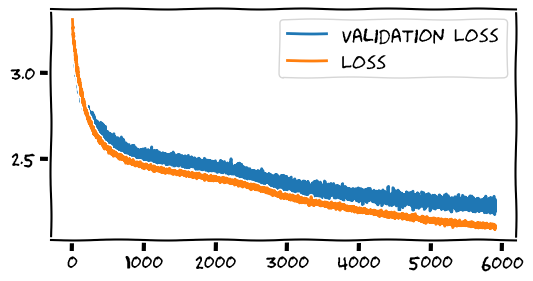

In [6]:
plt.figure(figsize=(6, 3))  
plt.plot(vlossi[100:], label='Validation Loss')
plt.plot(lossi[100:], label='Loss')
plt.legend()

In [7]:
string = "           \nKING RICHARD I"
print(string, end="")

with torch.no_grad():
    for _ in range(300):
        X = torch.tensor([texttoint[s] for s in string[-sequence_length:]]).long().view(1, -1).to(device)
        pred = model.forward(X)
        string += inttotext[torch.multinomial(F.softmax(pred[0, -1, :], dim=0), 1).item()]
        print(string[-1], end="")


           
KING RICHARD Itorch.Size([1, 20, 20])
Itorch.Size([1, 20, 20])
:torch.Size([1, 20, 20])

torch.Size([1, 20, 20])

torch.Size([1, 20, 20])
Ttorch.Size([1, 20, 20])
htorch.Size([1, 20, 20])
etorch.Size([1, 20, 20])
mtorch.Size([1, 20, 20])
,torch.Size([1, 20, 20])
 torch.Size([1, 20, 20])
ttorch.Size([1, 20, 20])
otorch.Size([1, 20, 20])
'torch.Size([1, 20, 20])
storch.Size([1, 20, 20])
 torch.Size([1, 20, 20])
ftorch.Size([1, 20, 20])
otorch.Size([1, 20, 20])
rtorch.Size([1, 20, 20])
itorch.Size([1, 20, 20])
ntorch.Size([1, 20, 20])
gtorch.Size([1, 20, 20])
etorch.Size([1, 20, 20])
 torch.Size([1, 20, 20])
htorch.Size([1, 20, 20])
etorch.Size([1, 20, 20])
 torch.Size([1, 20, 20])
ctorch.Size([1, 20, 20])
otorch.Size([1, 20, 20])
mtorch.Size([1, 20, 20])
utorch.Size([1, 20, 20])
storch.Size([1, 20, 20])
etorch.Size([1, 20, 20])
;torch.Size([1, 20, 20])

torch.Size([1, 20, 20])

torch.Size([1, 20, 20])
Gtorch.Size([1, 20, 20])
rtorch.Size([1, 20, 20])
atorch.Size([1, 20, 20])


# Transformers 

Transformers consist of many attention blocks and MLPs in sequence, with residual connections 

In [8]:
class Block(nn.Module): 
    def __init__(self, emb_size, head_size, hidden_size, n_layers):
        super().__init__()

        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att = Attention(emb_size, head_size)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc = FullyConnected(emb_size, emb_size, hidden_size, n_layers)

    def forward(self, x):          
        x = x + self.att(self.prenorm1(x)) 
        x = x + self.fc(self.prenorm2(x))
    
        return x

class Transformer(nn.Module): 
    def __init__(self, vocab_size, emb_size, n_blocks, head_size, hidden_size, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(sequence_length, emb_size)
        
        self.norm = nn.LayerNorm(emb_size)
        self.blocks = nn.ModuleList([Block(emb_size, head_size, hidden_size, n_layers) for _ in range(n_blocks)])
        self.LinOut = nn.Linear(emb_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x) + self.posemb(torch.arange(x.size(1)).to(x.device)) * .1

        for block in self.blocks:
            x = x + block(self.norm(x))
            
        x = self.LinOut(self.norm(x))
        return x
    

device = torch.device("cuda:0")
model = Transformer(vocab_size=vocab_size, emb_size=64, n_blocks=8, head_size=64, hidden_size=64, n_layers=2).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 6000
batch_size = 2048
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred.view(-1, 65), labels[indexes].to(device).view(-1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))
        loss = F.cross_entropy(pred[:, -1].view(-1, 65), val_labels[indexes].to(device).view(-1))
        vlossi.append(loss.item())

Millions of parameters: 0.28
torch.Size([2048, 20, 20])
torch.Size([2048, 20, 20])
torch.Size([2048, 20, 20])
torch.Size([2048, 20, 20])
torch.Size([2048, 20, 20])
torch.Size([2048, 20, 20])
torch.Size([2048, 20, 20])
torch.Size([2048, 20, 20])
Epoch ___0 - Loss: 4.402
torch.Size([256, 20, 20])
torch.Size([256, 20, 20])
torch.Size([256, 20, 20])
torch.Size([256, 20, 20])
torch.Size([256, 20, 20])
torch.Size([256, 20, 20])
torch.Size([256, 20, 20])
torch.Size([256, 20, 20])


ValueError: Expected input batch_size (256) to match target batch_size (5120).

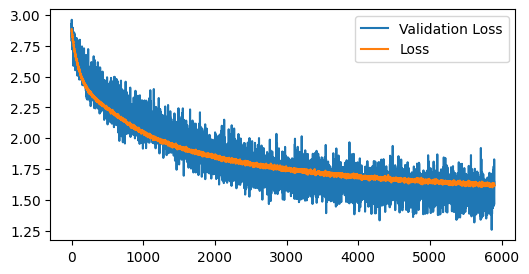

In [9]:
plt.figure(figsize=(6, 3))  
plt.plot(vlossi[100:], label='Validation Loss')
plt.plot(lossi[100:], label='Loss')
plt.legend()

In [13]:
class Block(nn.Module): 
    def __init__(self, emb_size, head_size, hidden_size, n_layers):
        super().__init__()

        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att = Attention(emb_size, head_size)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc = FullyConnected(emb_size, emb_size, hidden_size, n_layers)

    def forward(self, x):          
        x = x + self.att(self.prenorm1(x)) 
        x = x + self.fc(self.prenorm2(x))
    
        return x

class Transformer(nn.Module):
    def __init__(self, vocab_size, emb_size, n_blocks, head_size, hidden_size, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(sequence_length, emb_size)
        
        self.norms = nn.ModuleList([nn.LayerNorm(emb_size) for _ in range(n_blocks)])
        self.blocks = nn.ModuleList([Block(emb_size, head_size, hidden_size, n_layers) for _ in range(n_blocks)])
        self.norm_out = nn.LayerNorm(emb_size)
        self.LinOut = nn.Linear(emb_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x) + self.posemb(torch.arange(x.size(1)).to(x.device)) * 0.1
        
        for block, norm in zip(self.blocks, self.norms):
            x = x + block(norm(x))
        
        x = self.LinOut(self.norm_out(x))
        return x

device = torch.device("cuda:0")
model = Transformer(vocab_size=vocab_size, emb_size=64, n_blocks=8, head_size=64, hidden_size=64, n_layers=2).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 6000
batch_size = 2048
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred.view(-1, 65), labels[indexes].to(device).view(-1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))
        loss = F.cross_entropy(pred[:, -1].view(-1, 65), val_labels[indexes].to(device).view(-1))
        vlossi.append(loss.item())

Millions of parameters: 0.28
Epoch ___0 - Loss: 4.315
Epoch _600 - Loss: 2.154
Epoch 1200 - Loss: 1.932
Epoch 1800 - Loss: 1.827
Epoch 2400 - Loss: 1.750
Epoch 3000 - Loss: 1.706
Epoch 3600 - Loss: 1.687
Epoch 4200 - Loss: 1.642
Epoch 4800 - Loss: 1.634
Epoch 5400 - Loss: 1.601


# Speed 
The complexity of the transformer scales like this (with N = sequence_length): 
- Linear layers scale with O(N) because they are applied to a list of N tensors of the same size.
- Attention layers scale with O(N^2) because they are multiplying together Keys and Queries which both scale with N. 

So the transformers should generally scale linearly until the quadratic term becomes big enough to matter, and then they become very slow. 

In [11]:
class Block(nn.Module): 
    def __init__(self, emb_size, head_size, hidden_size, n_layers):
        super().__init__()

        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att = Attention(emb_size, head_size)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc = FullyConnected(emb_size, emb_size, hidden_size, n_layers)

    def forward(self, x):          
        x = x + self.att(self.prenorm1(x)) 
        x = x + self.fc(self.prenorm2(x))
    
        return x

class Transformer(nn.Module):
    def __init__(self, vocab_size, emb_size, n_blocks, head_size, hidden_size, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(sequence_length, emb_size)
        
        self.norms = nn.ModuleList([nn.LayerNorm(emb_size) for _ in range(n_blocks)])
        self.blocks = nn.ModuleList([Block(emb_size, head_size, hidden_size, n_layers) for _ in range(n_blocks)])
        self.norm_out = nn.LayerNorm(emb_size)
        self.LinOut = nn.Linear(emb_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x) + self.posemb(torch.arange(x.size(1)).to(x.device)) * 0.1
        
        for block, norm in zip(self.blocks, self.norms):
            x = x + block(norm(x))
        
        x = self.LinOut(self.norm_out(x))
        return x

device = torch.device("cuda:0")
model = Transformer(vocab_size=vocab_size, emb_size=64, n_blocks=8, head_size=64, hidden_size=64, n_layers=2).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 6000
batch_size = 2048
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred.view(-1, 65), labels[indexes].to(device).view(-1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))
        loss = F.cross_entropy(pred[:, -1].view(-1, 65), val_labels[indexes].to(device).view(-1))
        vlossi.append(loss.item())

Millions of parameters: 0.28
Epoch ___0 - Loss: 4.334


KeyboardInterrupt: 

In [15]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, emb_size, n_blocks, head_size, hidden_size, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(1024, emb_size)
        
        self.norms = nn.ModuleList([nn.LayerNorm(emb_size) for _ in range(n_blocks)])
        self.blocks = nn.ModuleList([Block(emb_size, head_size, hidden_size, n_layers) for _ in range(n_blocks)])
        self.norm_out = nn.LayerNorm(emb_size)
        self.LinOut = nn.Linear(emb_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x) + self.posemb(torch.arange(x.size(1)).to(x.device)) * 0.1
        
        for block, norm in zip(self.blocks, self.norms):
            x = x + block(norm(x))
        
        x = self.LinOut(self.norm_out(x))
        return x

device = torch.device("cuda:0")
model = Transformer(vocab_size=vocab_size, emb_size=16, n_blocks=8, head_size=16, hidden_size=16, n_layers=2).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")


Millions of parameters: 0.04


In [16]:
import time
import numpy as np

def measure_performance(sequence_length, tokens_per_batch=8192, N=3):
    batch_size = tokens_per_batch // sequence_length
    sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
    inputs = sequences[:50000, :-1]
    labels = sequences[:50000, 1:]

    tok_per_sec_list = []
    for _ in range(N):
        t0 = time.time()
        for i in range(50):
            indexes = torch.randint(0, len(inputs)-sequence_length, (batch_size,))
            
            pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
            loss = F.cross_entropy(pred.view(-1, 65), labels[indexes].to(device).view(-1))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        tok_per_sec = sequence_length * batch_size * 50 / (time.time() - t0) / 1e3
        tok_per_sec_list.append(tok_per_sec)

    mean_tok_per_sec = np.mean(tok_per_sec_list).item()
    std_tok_per_sec = np.std(tok_per_sec_list).item()
    return mean_tok_per_sec, std_tok_per_sec

sequence_lengths = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
time_data = []
time_data_std = []

for sequence_length in sequence_lengths:
    mean_tok_per_sec, std_tok_per_sec = measure_performance(sequence_length)
    time_data.append(1 / mean_tok_per_sec)  # Convert to seconds per token
    time_data_std.append(std_tok_per_sec / (mean_tok_per_sec ** 2))  # Convert to seconds per token

plt.errorbar(sequence_lengths, time_data, yerr=time_data_std, fmt='-o')
plt.xlabel('Sequence Length')
plt.ylabel('Seconds per Token')
plt.title('Performance with Constant Tokens per Batch')
plt.show()

# using bad hyperparameters

bad_sequence_lengths = [s + 1 for s in sequence_lengths[:7]]

bad_time_data = []
for sequence_length in bad_sequence_lengths:
    mean_tok_per_sec, std_tok_per_sec = measure_performance(sequence_length)
    bad_time_data.append(1 / mean_tok_per_sec)  # Convert to seconds per token

plt.plot(sequence_lengths, time_data, '-o', label='Good Hyperparameters')
plt.plot(bad_sequence_lengths, bad_time_data, '-o', label='Bad Hyperparameters')
plt.xlabel('Sequence Length')
plt.ylabel('Seconds per Token')
plt.title('Performance with Constant Tokens per Batch')
plt.legend()
plt.show()

KeyboardInterrupt: 

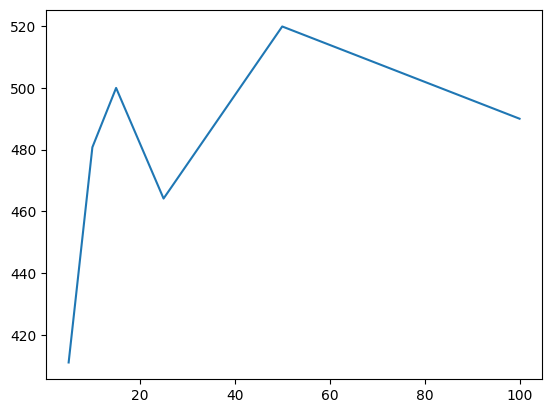

In [9]:
plt.plot([5, 10, 15, 25, 50, 100], time_data)

# Results
As you can see we can get really good loss with the transformer, this architecture should scale well up to GPT3.5 level performance with enough high quality data

In [10]:
print("Millions of parameters: ", round(sum(p.numel() for p in model.parameters() if p.requires_grad)/1000000, 2))
print([p.numel() for p in model.parameters() if p.requires_grad])

Millions of parameters:  0.28
[4160, 1280, 64, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 4160, 65]


In [11]:
model

Transformer(
  (embedding): Embedding(65, 64)
  (posemb): Embedding(20, 64)
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (blocks): ModuleList(
    (0-7): 8 x Block(
      (prenorm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (att): Attention(
        (keys): Linear(in_features=64, out_features=64, bias=True)
        (queries): Linear(in_features=64, out_features=64, bias=True)
        (values): Linear(in_features=64, out_features=64, bias=True)
        (rvalues): Linear(in_features=64, out_features=64, bias=True)
      )
      (prenorm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (fc): FullyConnected(
        (fc1): Linear(in_features=64, out_features=64, bias=True)
        (fcx): ModuleList(
          (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
        )
        (fc2): Linear(in_features=64, out_features=64, bias=True)
      )
    )
  )
  (LinOut): Linear(in_features=64, out_features=65, bias=True)
)

In [12]:
string = "           \nKING RICHARD I"
print(string, end="")

with torch.no_grad():
    for _ in range(300):
        X = torch.tensor([texttoint[s] for s in string[-sequence_length:]]).long().view(1, -1).to(device)
        pred = model.forward(X)
        string += inttotext[torch.multinomial(F.softmax(pred[0, -1, :], dim=0), 1).item()]
        print(string[-1], end="")


           
KING RICHARD II:
Is hoe
it have some in myself?

LANTIUS:
No more, for elden more say selvan his arm
ecrown hand we speak.

Sird My somet him thou what not true.

FLORIZEL:
But, to foul severe mock'd
Here womas for the capint and
To have Of her happules again that could same
In as in therefore, hell hoke speasure